In [1]:
import os
import sys
path_to_this_notebook = os.path.abspath('.')
PATH_TO_PROJECT = path_to_this_notebook[: path_to_this_notebook.find('notebooks')]
sys.path.append(PATH_TO_PROJECT)

In [2]:
from src.preprocessing.load_data import *
from src.preprocessing.filters import filter_recs_metadata, filter_sounds_metadata_extended
from src.preprocessing.process_sounds_metadata import extend_sounds_metadata, compute_epochs
from src.preprocessing.process_sounds_metadata import generate_sounds_metadata
from notebooks.analysis.plotting_config import ORDER
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from matplotlib import gridspec
from src.util import make_image
from IPython.display import clear_output
import matplotlib
%matplotlib inline

ModuleNotFoundError: No module named 'src.preprocessing'

In [273]:
path_to_recordings_metadata = PATH_TO_PROJECT + 'data/'
recordings_metadata_name = 'recordings_metadata.csv'

# what data to load
dates = 'all'
colonies = ['targaryen', 'martell', 'stark', 'arryn', 'lannister', 'baratheon', 'dothrakib']
experiments = 'all'
stages = ['labeled and checked', 'traced and checked', 'labeled', 'traced']

In [274]:
# specify paths, where data is stored
path_to_info = PATH_TO_PROJECT + 'data/rat_info.csv'
path_to_recordings_metadata = PATH_TO_PROJECT + 'data/'
recordings_metadata_name = 'recordings_metadata.csv'

# what data to load, set filters here
colonies = ['hvd','dam', 'nmr']
#colonies = 'all'
dates = 'all'
experiments = 'all'
stages = ['traced and checked', 'labeled and checked']
stages = 'all'

In [275]:
info = load_info_file(path_to_info)
recs_metadata = pd.read_csv(path_to_recordings_metadata + recordings_metadata_name, dtype={'ratids': str})
filters_mask = filter_recs_metadata(recs_metadata, dates = dates, colonies = colonies, 
                                         stages = stages, experiments = experiments)
recs_metadata = recs_metadata[filters_mask].reset_index(drop=True)
sounds_metadata = generate_sounds_metadata(recs_metadata)
txts_dict = {}
for rec_name, rec_path in recs_metadata[['name', 'path']].values:
    txt = pd.read_csv(rec_path + rec_name.replace('npy', 'txt'), sep='\t')
    txts_dict[rec_name] = txt

/home/nakedmoleratvoices/src/preprocessing/process_sounds_metadata.py:36: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  sounds_metadata = pd.concat(sounds_metadata, 0)


In [276]:
multi_rep_dict = {'multiplesoftchirps': ('sc', 2), 'multiplesoftchirps2': ('sc', 2), 
                 'multiplesoftchirps3': ('sc', 3), 'multiplesoftchirps4': ('sc', 4), 
                 'multiplesoftchirps5': ('sc', 5), 'multiplesoftchirps6': ('sc', 6),
                 'multiplesoftchirps7': ('sc', 7), 
                 'multipleloudchirp': ('lc', 2), 'multipleloudchirps2': ('lc', 2),
                 'multipleloudchirps3': ('lc', 3), 'multipleloudchirps4': ('lc', 4),
                 'multipleloudchirps5': ('lc', 5), 'multipleloudchirps6': ('lc', 6),
                 'multipleloudchirps7': ('lc', 7),
                 'multiplecombos': ('cm', 2), 'multiplecombos2': ('cm', 2),
                 'multiplecombos3': ('cm', 3), 'multiplecombos4': ('cm', 4),
                 'multiplecombos5': ('cm', 5), 'multiplecombos6': ('cm', 6), 
                 'multiplecombos7': ('cm', 7)}

#group_dict = {'softchirp': 'chirp', 'loudchirp': 'chirp'} 'class_name': 'group name'
group_dict = {}

class_to_multi = defaultdict(list)
for key, (cl, _) in multi_rep_dict.items():
    if cl == 'sc':
        cl = 'softchirp'
    elif cl == 'lc':
        cl = 'loudchirp'
    elif cl == 'cm':
        cl = 'combo'
    class_to_multi[cl].append(key)

In [286]:
not_sound_classes = ['badsplit', 'softchirp','noise' ] # Specifies what sounds are counted for the normalization
#classes_to_plot = ['softchirp', 'loudchirp', 'phee', 'tweet'] # What classes to plot
classes_to_plot = 'all'
classes_to_drop = ['cheveronphee', 'weirdo', 'sound',]
if classes_to_drop is None:
    classes_to_drop = []
all_notmulti_classes = set([cl for cl in sounds_metadata['cl'].unique() if 'multi' not in cl])
sound_classes = set(sounds_metadata['cl'].unique()) - set(not_sound_classes)
if classes_to_plot == 'all':
    classes_to_plot = set(all_notmulti_classes) - set(not_sound_classes) - set(classes_to_drop)
classes_to_consider = set(sounds_metadata['cl'].unique()) - set(not_sound_classes)

per_colony_class_occurences = defaultdict(lambda: defaultdict(lambda: 0))
per_colony_class_frequency = defaultdict(lambda: defaultdict(list))
#classes_to_plot = set()

for col in sounds_metadata.colony.unique():
    col_mask = sounds_metadata['colony'] == col
    sounds_metadata_col = sounds_metadata[col_mask].reset_index(drop=True)
    for rec_name in sounds_metadata_col['rec'].unique():
        txt = txts_dict[rec_name]
        duration = txt['e'].iloc[-1] - txt['s'].iloc[0]
        cl_occured_in_txt = defaultdict(lambda: 0)
        for ind, (s, e, cl) in enumerate(txt.values):
            if cl not in classes_to_consider:
                continue
            if 'multi' in cl:
                cl, rep = multi_rep_dict[cl]
                if cl == 'sc':
                    cl = 'softchirp'
                elif cl == 'lc':
                    cl = 'loudchirp'
                elif cl == 'cm':
                    cl = 'combo'
            else:
                rep = 1
            if cl in group_dict:
                cl = group_dict[cl]
            per_colony_class_occurences[col][cl] += rep
            cl_occured_in_txt[cl] += rep
            #classes_to_plot.add(cl)
        for cl in cl_occured_in_txt:
            per_colony_class_frequency[col][cl].append(60 * cl_occured_in_txt[cl] / duration)
            
ordering_function = lambda x: ORDER['cl'].index(x) if x in ORDER['cl'] else np.inf
classes_to_plot = sorted(classes_to_plot, key=ordering_function)

In [287]:
classes_to_plot

['cheveron',
 'combo',
 'combotwo',
 'downsweep',
 'grunt',
 'hiccup',
 'loudchirp',
 'mordent',
 'phee',
 'scream',
 'squawk',
 'sullarco',
 'tweet',
 'upsweep',
 'vtrill',
 'whistle']

,dam,hvd,nmr
cheveron,0.141140,0.038105,0.000000
combo,0.103124,0.028633,0.054737
combotwo,0.000109,0.000000,0.016867
downsweep,0.029277,0.119053,0.029340
grunt,0.008193,0.002476,0.011051
hiccup,0.002513,0.000000,0.000194
loudchirp,0.000328,0.000323,0.148378
mordent,0.001529,0.004629,0.000646
phee,0.152392,0.069537,0.007496
scream,0.272777,0.306028,0.002326


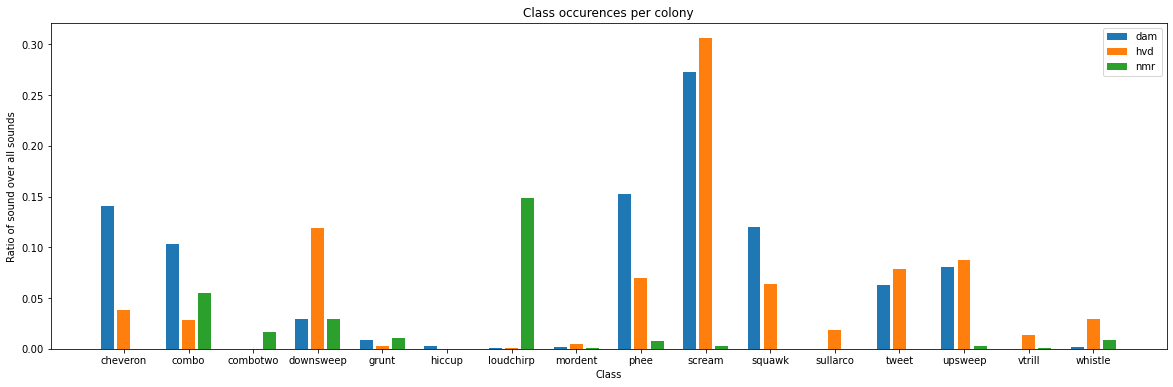

In [288]:
# Plot class occurences
plt.figure(figsize=(20, 6))
normalize = True

n_classes = len(classes_to_plot)
n_colonies = len(per_colony_class_frequency.keys())
x = np.arange(0, n_classes * (n_colonies + 1), 1)
x_ticks = np.arange((n_colonies - 1)/2, n_classes * (n_colonies + 1), n_colonies + 1)
classes_occurences = []
colonies_ordered = []

for col_ind, col in enumerate(per_colony_class_occurences.keys()):
    colonies_ordered.append(col)
    x_col = x[col_ind::(n_colonies + 1)]
    y_col = np.array([per_colony_class_occurences[col][cl] for cl in classes_to_plot])
    if normalize:
        y_col = y_col / sum(per_colony_class_occurences[col].values())
    classes_occurences.append(y_col)
    plt.bar(x_col, y_col, label=col)
_ = plt.legend()

plt.title('Class occurences per colony')
if normalize:
    plt.ylabel('Ratio of sound over all sounds')
else:
    plt.ylabel('Number of occurences')
    
_ = plt.xlabel('Class')
_ = plt.xticks(x_ticks, list(classes_to_plot))

df = pd.DataFrame(np.transpose(classes_occurences), columns=colonies_ordered,)
df.index = classes_to_plot
# Uncomment line below to save
# df.to_csv('classes_occurences.csv',)
plt.savefig("no softchirps.svg", format="svg")
df

,dam,hvd,nmr
cheveron,0.298386,0.087833,0.000000
combo,0.241970,0.108786,0.549222
combotwo,0.005447,0.000000,0.220214
downsweep,0.074022,0.419762,0.241227
grunt,0.053420,0.012740,0.108820
hiccup,0.036154,0.000000,0.066834
loudchirp,0.008224,0.008274,1.834342
mordent,0.019221,0.022712,0.028499
phee,0.415152,0.161218,0.100228
scream,0.611550,0.946696,0.048204


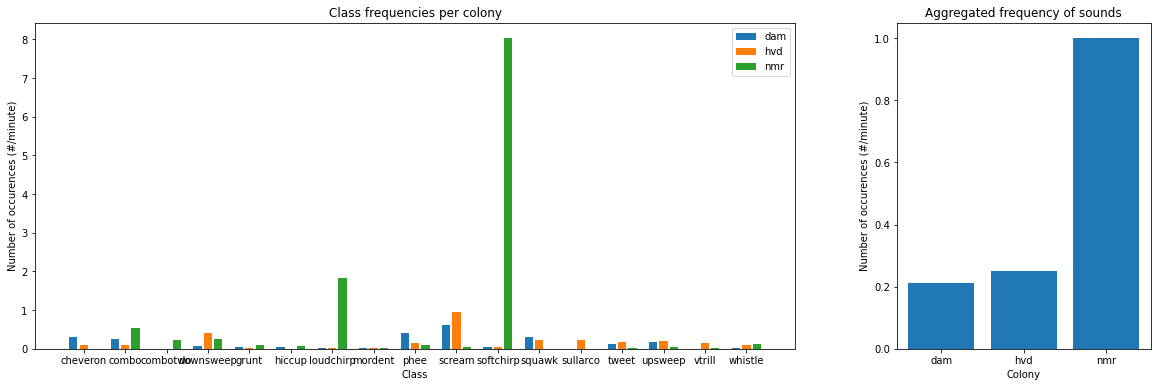

In [10]:

# Plot class frequencies
plt.figure(figsize=(20, 6))
normalize_by_max = True

gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
ax0 = plt.subplot(gs[0])
n_classes = len(classes_to_plot)
n_colonies = len(per_colony_class_frequency.keys())
x = np.arange(0, n_classes * (n_colonies + 1), 1)
x_ticks = np.arange((n_colonies - 1)/2, n_classes * (n_colonies + 1), n_colonies + 1)
total_frequency_per_colony = {}

classes_frequencies = []
colonies_ordered = []


for col_ind, col in enumerate(per_colony_class_occurences.keys()):
    colonies_ordered.append(col)
    x_col = x[col_ind::(n_colonies + 1)]
    empty_mean = lambda x: np.mean(x) if len(x) else 0
    y_col = np.array([empty_mean(per_colony_class_frequency[col][cl]) for cl in classes_to_plot])
    classes_frequencies.append(y_col)
    plt.bar(x_col, y_col, label=col)
    total_frequency_per_colony[col] = np.nansum(y_col)
_ = plt.legend()

plt.title('Class frequencies per colony')

plt.ylabel('Number of occurences (#/minute)')
_ = plt.xlabel('Class')
_ = plt.xticks(x_ticks, list(classes_to_plot))
ax1 = plt.subplot(gs[1])

y = [total_frequency_per_colony[col] for col in per_colony_class_frequency]
if normalize_by_max:
    y = [yi/max(y) for yi in y]

plt.bar(per_colony_class_frequency.keys(), y)
_ = plt.title('Aggregated frequency of sounds')
plt.ylabel('Number of occurences (#/minute)')
_ = plt.xlabel('Colony')

df = pd.DataFrame(np.transpose(classes_frequencies), columns=colonies_ordered,)
df.index = classes_to_plot
# Uncomment line below to save
# df.to_csv('classes_occurences.csv',)
#plt.savefig("class_frequences_without soft chirps_normalized to max_001_17sept2021.svg", format="svg")
df

In [10]:
# This cell is super slow !!! 
total_durations = defaultdict(lambda: 0)
recs_durations = dict()
for rec_name, rec_path, colony in recs_metadata[['name', 'path', 'colony']].values:
    rec = np.load(rec_path + rec_name)
    duration = rec.shape[0] / 22050
    print('%s colony %s lasts for %.2f minutes' % (colony, rec_name, duration / 60))
    total_durations[colony] += duration
    recs_durations[rec_name] = duration
    del(rec)
    
for col, dur in total_durations.items():
    print('Total duration of recordings from %s is %.2f minutes' % (col, dur/60))

dam colony dam_01092019 Mic 2 Com 6 Vid Left Part 4_ptB.npy lasts for 41.87 minutes
dam colony dam_30082019 Mic 2 Com 6 Vid Left  Part 7.npy lasts for 186.00 minutes
dam colony dam_30082019 Mic 2 Com 6 Vid Left  Part 3.npy lasts for 0.89 minutes
dam colony dam_01092019 Mic 2 Com 6 Vid Left Part 5_ptD.npy lasts for 60.92 minutes
dam colony dam_30082019 Mic 2 Com 6 Vid Left  Part 8.npy lasts for 186.00 minutes
dam colony dam_01092019 Mic 2 Com 6 Vid Left Part 6_ptB.npy lasts for 42.00 minutes
dam colony dam_30082019 Mic 2 Com 6 Vid Left  Part 4.npy lasts for 186.00 minutes
dam colony dam_30082019 Mic 2 Com 6 Vid Left  Part 1.npy lasts for 186.00 minutes
dam colony dam_01092019 Mic 2 Com 6 Vid Left Part 1_ptA.npy lasts for 42.00 minutes
dam colony dam_01092019 Mic 2 Com 6 Vid Left Part 1_ptD.npy lasts for 61.18 minutes
dam colony dam_31082019 Mic 2 Com 6 Vid Left Part 3.npy lasts for 186.00 minutes
dam colony dam_01092019 Mic 2 Com 6 Vid Left Part 8_ptC.npy lasts for 42.00 minutes
dam col

nmr colony nmr_22082019 Mic2  Tag 6 Vid Left_ptD.npy lasts for 33.43 minutes
nmr colony nmr_28082019 Mic 2 Tag 6 Vid Left Part 4_ptE.npy lasts for 19.70 minutes
nmr colony nmr_29082019 Mic 2 Tag 6 Vid Left Part 2_ptC.npy lasts for 33.55 minutes
nmr colony nmr_23082019 Mic 2 Tag 6 Vid Left Part 2_ptA.npy lasts for 13.40 minutes
nmr colony nmr_2602019 Mic 2 Tag 6 Vid Left Part 2_ptC_annotated.npy lasts for 84.53 minutes
nmr colony nmr_28082019 Mic 2 Tag 6 Vid Left Part 5_ptD.npy lasts for 45.74 minutes
nmr colony nmr_26082019 Mic 2 Tag 6 Vid Left Part 1_ptF.npy lasts for 74.28 minutes
nmr colony nmr_22082019 Mic2  Tag 6 Vid Left_ptE.npy lasts for 33.43 minutes
nmr colony nmr_28082019 Mic 2 Tag 6 Vid Left Part 4_ptA.npy lasts for 41.74 minutes
nmr colony nmr_28082019 Mic 2 Tag 6 Vid Left Part 5_ptC.npy lasts for 33.64 minutes
nmr colony nmr_2602019 Mic 2 Tag 6 Vid Left Part 2_ptB_annotated.npy lasts for 82.97 minutes
nmr colony nmr_23082019 Mic 2 Tag 6 Vid Left Part 1_ptB.npy lasts for 83

KeyboardInterrupt: 

In [11]:
# Recording as a line
rec_name = recs_metadata['name'].iloc[50]
txt = txts_dict[rec_name]
# Specify what part of the recording to take
start = 1850
end = 2000
ind_start = np.where(txt['s'] >= start)[0][0]
ind_end = np.where(txt['s'] >= end)[0][0]
txt = txt[ind_start: ind_end]
print(txt['cl'].value_counts())
if len(txt):
    duration = txt['e'].iloc[-1] - txt['e'].iloc[0]
else:
    print('No sounds in the recording!')
print('Recording', rec_name, '\nDuration', duration)


scream       20
noise         4
badsplit      2
phee          2
downsweep     1
grunt         1
hiccup        1
squawk        1
upsweep       1
combo         1
Name: cl, dtype: int64
Recording dam_29082019 Mic 2 Com 6 Vid Left  Part 4.npy 
Duration 135.64430166340026


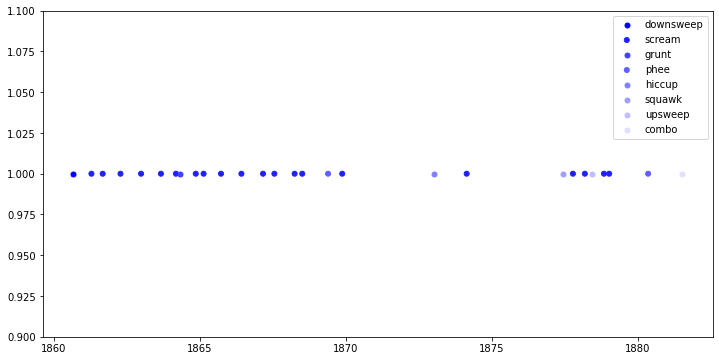

In [12]:
plt.figure(figsize=(12, 6))

classes_to_drop = ['noise', 'badsplit']
unique_classes = [cl for cl in txt['cl'].unique() if cl not in classes_to_drop]

cl_to_marker = {cl: '.' for cl in unique_classes} 
# List of markers https://matplotlib.org/stable/api/markers_api.html?highlight=marker#module-matplotlib.markers
cl_to_marker_size = {cl: 100 for cl in unique_classes}
cl_to_color = {}
for ind, cl in enumerate(unique_classes):
    r = ind/len(unique_classes)
    cl_to_color[cl] = (r, r, 1) # the colors are in RGB (r, r, 1),
                                # where r goes from 0 to 1 with step 1/n_classes. I.g. for 5 classes it will be 
                                # (0, 0, 1), (0.2, 0.2, 1), (0.4, 0.4, 1), ..., (0.8, 0.8, 1)
                                # Change it as you wish.
    

for cl in unique_classes:
    txt_cl = txt[txt['cl'] == cl]
    x_cl, y_cl = [], []
    
    m = cl_to_marker[cl]
    c = cl_to_color[cl]
    size = cl_to_marker_size[cl]
    
    for s, e, cl in txt_cl.values:
        if cl in classes_to_drop:
            continue
        x_cl.append((s + e) / 2)
        y_cl.append(1)
    plt.scatter(x_cl, y_cl, c=[c] * len(x_cl), marker=m, s=size, label=cl)
_ = plt.legend()
_ = plt.ylim(0.9, 1.1)

In [262]:
# Sample random recording
col = 'hvd'

while True:
    inds = np.where(recs_metadata['colony'] == col)[0]
    rec_ind = np.random.choice(inds)
    rec_name, rec_path = recs_metadata[['name', 'path']].iloc[rec_ind]
    txt = txts_dict[rec_name]
    print(rec_name)
    print('Sounds in the recording:')
    print(txt['cl'].value_counts())
    print('Press enter to confirm the recording, type anything to sample another one')
    if input() == '':
        break
    else:
        clear_output(wait=True)
rec = np.load(rec_path + rec_name)
    


hvd_04092019 Mic 2 Com 13 Vid Mid Part 8.npy
Sounds in the recording:
weirdo       101
downsweep     86
scream        65
noise         52
phee          47
upsweep       41
squawk        36
whistle       28
tweet         27
cheveron      26
vtrill        20
sullarco      18
badsplit       9
combo          9
softchirp      4
mordent        2
grunt          1
Name: cl, dtype: int64
Press enter to confirm the recording, type anything to sample another one



Timestamps: 258.3544 - 258.4731


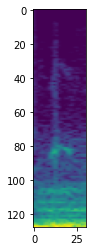

In [267]:
# Sample random sound from the recorindg
cl = 'softchirp'
cl_ind = np.random.choice(np.where(txt['cl'] == cl)[0])
s, e = txt[['s', 'e']].iloc[cl_ind]
s_int, e_int = int(22050 * s), int(22050 * e)
sound = rec[s_int: e_int]
print('Timestamps: %.4f - %.4f' % (s, e))
plt.imshow(make_image(sound))